/home/sabina_alieva/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 2.2.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May 15 2025 21:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


May 24 20:34:03 NodeManager::prepare_nodes [Info]: 
    Preparing 101 nodes for simulation.

May 24 20:34:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 101
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

May 24 20:34:03 SimulationManager::run [Info]: 
    Simulation finished.


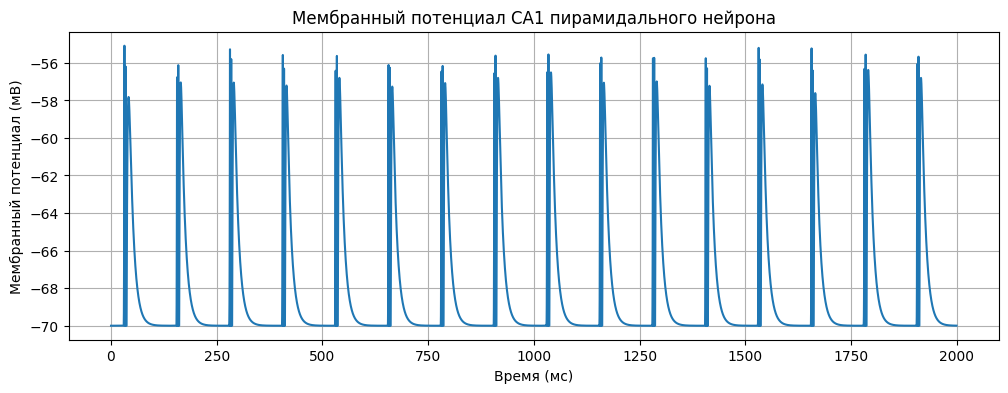

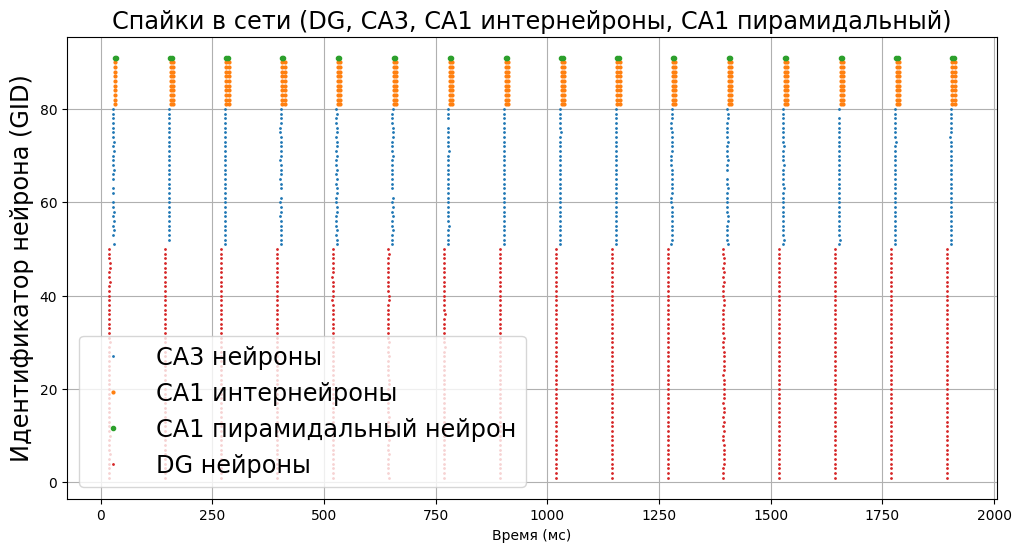

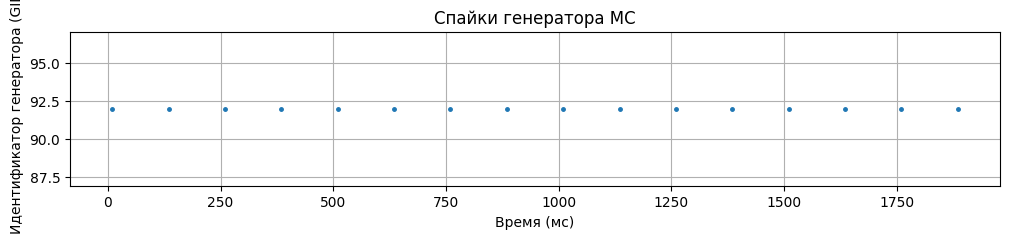

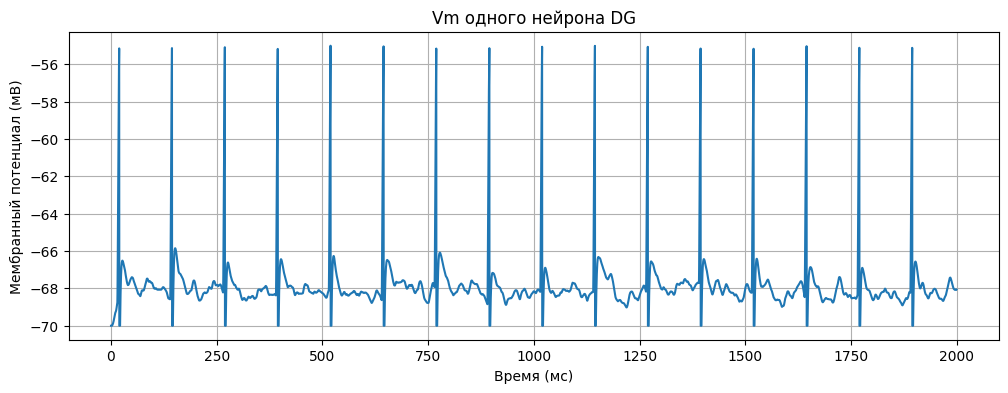

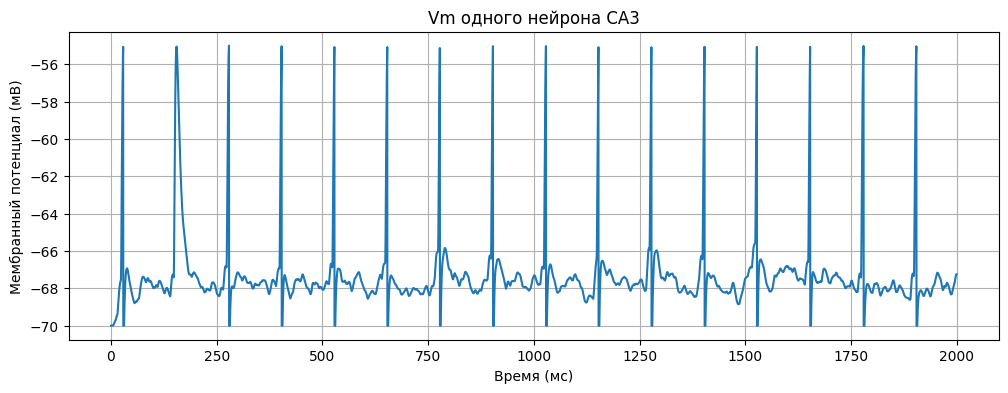

In [1]:
import nest
import matplotlib.pyplot as plt
import numpy as np

nest.ResetKernel()

# --- Параметры сети ---

n_dg_neurons = 50 # Количество гранулярных клеток в DG
ca3_total_neurons = 30 # Количество пирамидальных клеток в CA3
n_ca1_interneurons = 10 # Количество тормозных интернейронов в CA1

theta_frequency_hz = 8.0 # Частота тета-ритма в Гц
theta_period_ms = 1000.0 / theta_frequency_hz # Период тета-ритма в мс

ec_noise_rate = 1000.0 # Частота Пуассоновского генератора ЭК в Гц (на один генератор)

# -----Параметры для синапсов от генератора ЭК----

# ЭК -> DG (медиальный перфорантный путь) - возбуждающий
weight_ec_to_dg = 8.0 # Вес синапса от ЭК к DG
delay_ec_to_dg = 2.0 # Задержка от ЭК к DG

# ЭК -> CA3 (латеральный перфорантный путь) - возбуждающий
weight_ec_to_ca3 = 10.0 # Вес синапса от ЭК к CA3
delay_ec_to_ca3 = 3.0 # Задержка от ЭК к CA3

# -----Параметры для синапсов от МС генератора----
weight_ms_to_dg = 1170.0 # Вес синапсов от МС к DG (возбуждающий)
delay_ms_to_dg = 5.0 # Задержка от МС к DG

weight_ms_to_ca3 = 100.0 # Вес синапсов от МС к CA3 (возбуждающий)
delay_ms_to_ca3 = 5.0 # Задержка от МС к CA3

# ---Параметры для синапсов моховидных волокон (DG -> CA3)---
weight_dg_to_ca3_mossy = 200.0 # Вес моховидных волокон DG -> CA3 (очень сильный!)
delay_dg_to_ca3_mossy = 4.0 # Задержка моховидных волокон
indegree_dg_to_ca3 = 5 # Каждый нейрон CA3 получает 5 связей от случайных нейронов DG

# ---Параметры для синапсов CA3 -> CA1 пирамидальный---
synaptic_weight_ca3_ca1_pyr = 200.0 # Вес синапса от CA3 к пирамидальному нейрону CA1 (возбуждающий)
synaptic_delay_ca3_ca1_pyr = 2.0 # Задержка синапса от CA3 к пирамидальному нейрону CA1

# ---Параметры для синапсов CA3 -> CA1 интернейроны---
weight_ca3_to_interneuron = 100.0 # Вес синапсов от CA3 к интернейонам (возбуждающий)
delay_ca3_to_interneuron = 1.5 # Задержка от CA3 к интернейонам

# ---Параметры для синапсов CA1 интернейроны -> CA1 пирамидальный---
synaptic_weight_ca1_inh_ca1_pyr = -20.0 # Вес тормозного синапса от интернейронов к пирамидальному нейрону (отрицательный!)
synaptic_delay_ca1_inh_ca1_pyr = 1.0 # Задержка тормозного синапса
#На графике нет гиперполяризации, потому что текущая модель использует торможение, основанное на инъекции тока, которое физически не может опустить мембранный потенциал ниже потенциала покоя.

simulation_time_ms = 2000.0 # ---Время симуляции в мс---

# --- Создание узлов ---

# ----Клетки---
# Создаём популяцию гранулярных клеток зубчатой извилины (DG)
dg_population = nest.Create("iaf_psc_alpha", n_dg_neurons)

# Создаём популяцию CA3 (возбуждающие)
ca3_population = nest.Create("iaf_psc_alpha", ca3_total_neurons)

# Создаём популяцию тормозных интернейронов в CA1
ca1_interneurons = nest.Create("iaf_psc_alpha", n_ca1_interneurons)

# Создаём одну CA1 клетку (пирамидальный нейрон, возбуждающий)
ca1_cell = nest.Create("iaf_psc_alpha", 1)

# ---Генераторы---
# Создаём генератор тета-ритма (имитация входа от МС)
ms_theta_generator = nest.Create("spike_generator")
# Вычисляем времена спайков для тета-ритма на протяжении всей симуляции
spike_times_ms = np.arange(10.0, simulation_time_ms, theta_period_ms) # simulation_time_ms теперь определена
ms_theta_generator.set({"spike_times": spike_times_ms.tolist()}) # Устанавливаем времена спайков

# Создаём генератор шума от Энторинальной коры (ЭК)
ec_noise_generator = nest.Create("poisson_generator")
ec_noise_generator.set({"rate": ec_noise_rate}) # Устанавливаем частоту генератора

# ---Устройства записи---
# Мультиметр для CA1 пирамидального
multimeter = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
#  Мультиметры для проверки входящих токов в DG и CA3
multimeter_dg_check = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
multimeter_ca3_check = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})


spike_rec_ca1 = nest.Create("spike_recorder") # Рекордер спайков для CA1 пирамидального
spike_rec_ca3 = nest.Create("spike_recorder") # Рекордер спайков для популяции CA3
spike_rec_ca1_interneurons = nest.Create("spike_recorder") # Рекордер спайков для интернейронов CA1
spike_rec_dg = nest.Create("spike_recorder") # Рекордер спайков для популяции DG
generator_recorder = nest.Create("spike_recorder")#  Рекордер для проверки генератора МС

# --- Соединения ---

# ---Генераторы---
# Соединяем генератор тета-ритма МС с популяцией DG (возбуждающие синапсы)
nest.Connect(ms_theta_generator, dg_population, syn_spec={"weight": weight_ms_to_dg, "delay": delay_ms_to_dg}, conn_spec={"rule": "all_to_all"})

# Соединяем генератор тета-ритма МС с популяцией CA3 (возбуждающие синапсы)
nest.Connect(ms_theta_generator, ca3_population, syn_spec={"weight": weight_ms_to_ca3, "delay": delay_ms_to_ca3}, conn_spec={"rule": "all_to_all"})

# Соединяем генератор шума ЭК с популяцией DG (возбуждающие синапсы)
# Используем rule "all_to_all", предполагая, что генератор имитирует множество входов
nest.Connect(ec_noise_generator, dg_population, syn_spec={"weight": weight_ec_to_dg, "delay": delay_ec_to_dg}, conn_spec={"rule": "all_to_all"})

# Соединяем генератор шума ЭК с популяцией CA3 (возбуждающие синапсы)
nest.Connect(ec_noise_generator, ca3_population, syn_spec={"weight": weight_ec_to_ca3, "delay": delay_ec_to_ca3}, conn_spec={"rule": "all_to_all"})

# ---Клетки---
# Соединяем популяцию DG с популяцией CA3 (моховидные волокна)
# Используем правило fixed_indegree на целевой популяции CA3
nest.Connect(dg_population, ca3_population, syn_spec={"weight": weight_dg_to_ca3_mossy, "delay": delay_dg_to_ca3_mossy}, conn_spec={"rule": "fixed_indegree", "indegree": indegree_dg_to_ca3})

# Соединяем популяцию CA3 с популяцией тормозных интернейронов CA1 (возбуждающие синапсы)
nest.Connect(ca3_population, ca1_interneurons, syn_spec={"weight": weight_ca3_to_interneuron, "delay": delay_ca3_to_interneuron}, conn_spec={"rule": "all_to_all"})

# Соединяем популяцию CA3 с CA1 нейроном (возбуждающие синапсы)
nest.Connect(ca3_population, ca1_cell, syn_spec={"weight": synaptic_weight_ca3_ca1_pyr, "delay": synaptic_delay_ca3_ca1_pyr}, conn_spec={"rule": "all_to_all"})

# Соединяем тормозные интернейроны CA1 с пирамидальным нейроном CA1 (тормозные синапсы)
nest.Connect(ca1_interneurons, ca1_cell, syn_spec={"weight": synaptic_weight_ca1_inh_ca1_pyr, "delay": synaptic_delay_ca1_inh_ca1_pyr}, conn_spec={"rule": "all_to_all"})

# ---Соединяем устройства записи---
nest.Connect(multimeter, ca1_cell) # Мультиметр к CA1 пирамидальному (вход)
nest.Connect(ca1_cell, spike_rec_ca1) # CA1 пирамидальный к рекордеру (выход)
nest.Connect(ca3_population, spike_rec_ca3) # Популяция CA3 к рекордеру спайков CA3
nest.Connect(ca1_interneurons, spike_rec_ca1_interneurons)# Интернейроны CA1 к их рекордеру спайков
nest.Connect(dg_population, spike_rec_dg) # Популяция DG к их рекордеру спайков
nest.Connect(ms_theta_generator, generator_recorder) # Соединяем генератор МС с рекордером для проверки

# Подключаем мультиметр к первому нейрону в популяции DG
nest.Connect(multimeter_dg_check, dg_population[0])
# Подключаем мультиметр к первому нейрону в популяции CA3
nest.Connect(multimeter_ca3_check, ca3_population[0])

# --- Запуск симуляции ---

nest.Simulate(simulation_time_ms)

# --- Получение и построение графиков ---

# Получаем данные с мультиметра CA1
dmm_events = multimeter.get("events") # Получаем весь словарь событий
Vms = dmm_events["V_m"] # Получаем список значений Vm по ключу "V_m"
ts_vm = dmm_events["times"] # Получаем список времен по ключу "times"

# Получаем данные со всех рекордеров
events_ca1_pyr = spike_rec_ca1.get("events") # Получаем словарь событий
senders_ca1_pyr = events_ca1_pyr["senders"]
ts_spikes_ca1_pyr = events_ca1_pyr["times"]

events_ca3 = spike_rec_ca3.get("events") # Получаем словарь событий
senders_ca3 = events_ca3["senders"]
ts_spikes_ca3 = events_ca3["times"]

events_ca1_interneurons = spike_rec_ca1_interneurons.get("events")
senders_ca1_interneurons = events_ca1_interneurons["senders"]
ts_spikes_ca1_interneurons = events_ca1_interneurons["times"]

events_dg = spike_rec_dg.get("events") # Получаем словарь событий
senders_dg = events_dg["senders"]
ts_spikes_dg = events_dg["times"]

# Получаем данные с рекордера генератора МС
gen_events = generator_recorder.get("events")
gen_senders = gen_events["senders"]
gen_times = gen_events["times"]

#  Получаем данные с мультиметров проверки
dmm_dg_events = multimeter_dg_check.get("events")
Vms_dg_check = dmm_dg_events["V_m"]
ts_vm_dg_check = dmm_dg_events["times"]

dmm_ca3_events = multimeter_ca3_check.get("events")
Vms_ca3_check = dmm_ca3_events["V_m"]
ts_vm_ca3_check = dmm_ca3_events["times"]

# График мембранного потенциала CA1 пирамидального
plt.figure(figsize=(12, 4))
plt.plot(ts_vm, Vms)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Мембранный потенциал CA1 пирамидального нейрона")
plt.grid(True)

# График спайков (Raster Plot) для всех нейронов
plt.figure(figsize=(12, 6))
plt.plot(ts_spikes_ca3, senders_ca3, ".", markersize=2, label="CA3 нейроны")
plt.plot(ts_spikes_ca1_interneurons, senders_ca1_interneurons, ".", markersize=4, label="CA1 интернейроны")
plt.plot(ts_spikes_ca1_pyr, senders_ca1_pyr, ".", markersize=6, label="CA1 пирамидальный нейрон")
plt.plot(ts_spikes_dg, senders_dg, ".", markersize=2, label="DG нейроны")
plt.xlabel("Время (мс)")
plt.ylabel("Идентификатор нейрона (GID)",fontsize='xx-large')
plt.title("Спайки в сети (DG, CA3, CA1 интернейроны, CA1 пирамидальный)",fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.grid(True)

# График спайков генератора МС
plt.figure(figsize=(12, 2))
plt.plot(gen_times, gen_senders, ".", markersize=5)
plt.xlabel("Время (мс)")
plt.ylabel("Идентификатор генератора (GID)")
plt.title("Спайки генератора МС")
plt.grid(True)

# График мембранного потенциала одного нейрона DG
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_dg_check, Vms_dg_check)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Vm одного нейрона DG")
plt.grid(True)

# График мембранного потенциала одного нейрона CA3
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_ca3_check, Vms_ca3_check)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Vm одного нейрона CA3")
plt.grid(True)

# Сброс ядра NEST
nest.ResetKernel()